In [1]:
import torch 
from torchvision import datasets 

data_path = "./data"

In [2]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:21<00:00, 7835549.67it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [9]:
len(cifar10)

50000

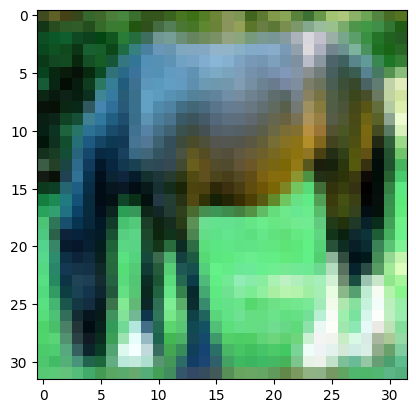

In [32]:
import numpy as np
import matplotlib.pyplot as plt

ind = np.random.randint(0, len(cifar10))

df = cifar10.data[ind]
plt.imshow(df)
plt.show()


In [33]:
img, label = cifar10[99]
img, label, cifar10.classes[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

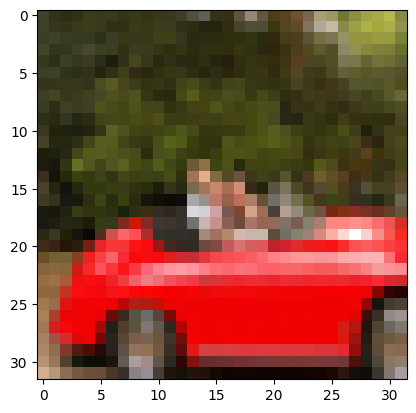

In [34]:
plt.imshow(img)

In [37]:
from torchvision import transforms 
to_tensor = transforms.ToTensor()
imt_t = to_tensor(img)
imt_t.shape

torch.Size([3, 32, 32])

In [38]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

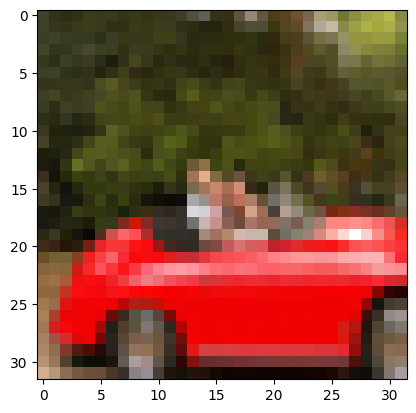

In [42]:
img_t, _ = tensor_cifar10[99]
type(img_t)
img_t.shape, img_t.dtype
img_t.min(), img_t.max()  
plt.imshow(img_t.permute(1, 2, 0)) 

In [43]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)

In [46]:
imgs.view(3, -1).mean(dim=1), imgs.view(3, -1).std(dim=1)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [47]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))


Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [48]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


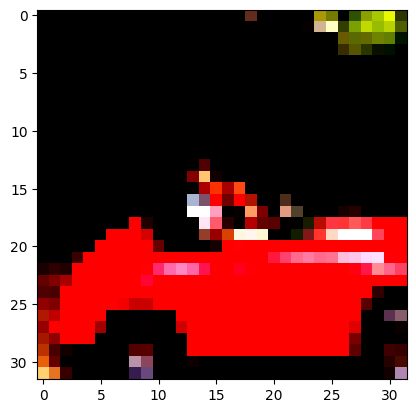

In [49]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))

In [66]:
retransposed_img = img_t * torch.tensor((0.2470, 0.2435, 0.2616)).unsqueeze(1).unsqueeze(2) + torch.tensor((0.4915, 0.4823, 0.4468)).unsqueeze(1).unsqueeze(2)

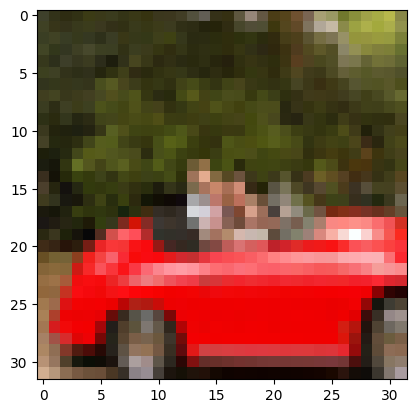

In [70]:
plt.imshow(retransposed_img.permute(1, 2, 0))

In [71]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]

In [87]:
import torch.nn as nn 

n_out = 2
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.LogSoftmax(dim=1)
)

In [76]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [77]:
softmax(x).sum()

tensor(1.)

In [79]:
import torch.nn as nn

softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])
softmax(x)


tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [83]:
img, _ = cifar2[0]

img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [85]:
out = model(img_batch)
out

tensor([[0.5301, 0.4699]], grad_fn=<SoftmaxBackward0>)

In [86]:
_, index = torch.max(out, dim=1)
index

tensor([0])

In [91]:
loss = nn.NLLLoss()

img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))


tensor(0.5582, grad_fn=<NllLossBackward0>)

In [125]:
import torch 
import torch.nn as nn 
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(), 
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in train_loader:
        batch_size = img.shape[0]
        outputs = model(img.view(batch_size, -1))
        loss = loss_fn(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {float(loss)}")

    correct = 0
    total = 0
    with torch.no_grad():
        for img, label in val_loader:
            outputs = model(img.view(img.shape[0], -1))
            _, predicted = torch.max(outputs, dim=1)
            total += label.shape[0]
            correct += int((predicted == label).sum())
    print(f"Accuracy: {correct / total}")

Epoch: 0, Loss: 0.41636747121810913
Accuracy: 0.7755
Epoch: 1, Loss: 0.5248256325721741
Accuracy: 0.7907
Epoch: 2, Loss: 0.5225838422775269
Accuracy: 0.7974
Epoch: 3, Loss: 0.3869682550430298
Accuracy: 0.8003
Epoch: 4, Loss: 0.4524211883544922
Accuracy: 0.8099
Epoch: 5, Loss: 0.508613646030426
Accuracy: 0.8042
Epoch: 6, Loss: 0.27827921509742737
Accuracy: 0.8121
Epoch: 7, Loss: 0.5665607452392578
Accuracy: 0.8279
Epoch: 8, Loss: 0.6796146631240845
Accuracy: 0.8304
Epoch: 9, Loss: 0.4623705744743347
Accuracy: 0.8309
Epoch: 10, Loss: 0.45818445086479187
Accuracy: 0.8392
Epoch: 11, Loss: 0.36594849824905396
Accuracy: 0.8322
Epoch: 12, Loss: 0.41888582706451416
Accuracy: 0.8407
Epoch: 13, Loss: 0.44806817173957825
Accuracy: 0.8147
Epoch: 14, Loss: 0.4532856345176697
Accuracy: 0.8103
Epoch: 15, Loss: 0.37191012501716614
Accuracy: 0.8274
Epoch: 16, Loss: 0.6303851008415222
Accuracy: 0.7335
Epoch: 17, Loss: 0.2570122480392456
Accuracy: 0.8633
Epoch: 18, Loss: 0.20888841152191162
Accuracy: 0.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Predicted: airplane, Actual: airplane')

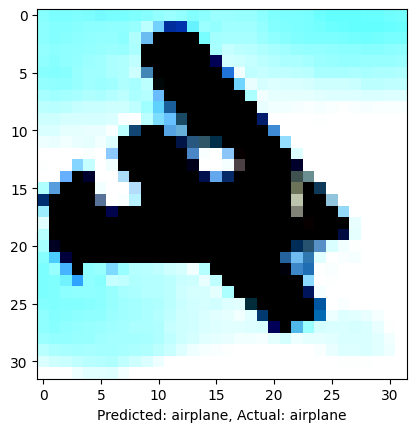

In [126]:
ind_test = np.random.randint(0, len(cifar2_val))
img_test, label_test = cifar2_val[ind_test]
out_test = model(img_test.view(-1).unsqueeze(0))
_, index_test = torch.max(out_test, dim=1)


plt.imshow(img_test.permute(1, 2, 0))
plt.xlabel(f"Predicted: {class_names[index_test]}, Actual: {class_names[label_test]}")

In [127]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [128]:
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'Layer: {name}, Weight Size: {param.size()}')
    elif 'bias' in name:
        print(f'Layer: {name}, Bias Size: {param.size()}')

Layer: 0.weight, Weight Size: torch.Size([1024, 3072])
Layer: 0.bias, Bias Size: torch.Size([1024])
Layer: 2.weight, Weight Size: torch.Size([512, 1024])
Layer: 2.bias, Bias Size: torch.Size([512])
Layer: 4.weight, Weight Size: torch.Size([128, 512])
Layer: 4.bias, Bias Size: torch.Size([128])
Layer: 6.weight, Weight Size: torch.Size([2, 128])
Layer: 6.bias, Bias Size: torch.Size([2])
